In [1]:
import valjax.endy as vj
import jax
import jax.numpy as npx
import numpy as np0
from jax import lax
from scipy.optimize import fsolve

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('../config/clean.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# fixed params
T = 2500 # max number of iterations (time periods)
N = 100 # number of capital grid points
Δ = 0.2 # time step for value function
μ = 0.5 # updating speed for value function
ϵ = 1e-6 # minimal consumption value
σ = 10 # how steep sigmoid for winding
f_lo, f_hi = 0.5, 2.0 # proportional grid range

In [5]:
# simple parameters
par0 = {
    'ρ': 0.05,
    'δ': 0.1,
    'α': 0.35,
    'γ': 10.0,
    'η': 3.0,
    'z': 1.0,
}

In [6]:
# technical functions
def smoothstep(x, np=npx):
    return np.where(x > 0, np.where(x < 1, 3*x**2 - 2*x**3, 1), 0)
def sigstep(x, σ=1, np=npx):
    return smoothstep(0.5*(σ*x+1), np=np)

In [7]:
# defined functions
def prod(k, z, α, np=npx):
    return z*k**α
def prodp(k, z, α, np=npx):
    return α*z*k**(α-1)
def util(c, np=npx):
    u0 = np.log(ϵ) + (c/ϵ-1)
    u1 = np.log(np.maximum(ϵ, c))
    return np.where(c >= ϵ, u1, u0)
def utilp(c, np=npx):
    c1 = np.maximum(ϵ, c)
    return 1/c1
def cost(i, γ, η, np=np):
    ib = np.maximum(0, i)
    return γ*(ib**η)
def costp(i, γ, η, np=npx):
    ib = np.maximum(0, i)
    return γ*η*(ib**(η-1))

In [8]:
# find steady state capital
def kss_func(k, par, np=npx):
    ρ, δ, z, α, γ, η = par['ρ'], par['δ'], par['z'], par['α'], par['γ'], par['η']
    i = δ*k
    y = prod(k, z, α, np=np)
    fp = prodp(k, z, α, np=np)
    v_k = fp/(ρ+δ)
    dp = costp(i, γ, η, np=np)
    return dp - v_k
k_ss, = fsolve(lambda k: kss_func(k, par0), 1)
print(k_ss)

2.1685622389615395


In [9]:
# construct capital grid
k_min = f_lo*k_ss
k_max = f_hi*k_ss
k_grid = npx.linspace(k_min, k_max, N)

In [10]:
def value(par, grid, st, tv, np=npx):
    ρ, δ, γ, η = par['ρ'], par['δ'], par['γ'], par['η']
    y_vals = grid['y']
    v_vals, i_vals = st['vn'], st['iv']

    # find important terms
    d_cost = cost(i_vals, γ, η, np=np)
    c_vals = y_vals - d_cost
    u_vals = util(c_vals, np=np)
    k_diff = i_vals - δ*k_grid

    # interpolate v-prime
    k_next = k_grid + Δ*k_diff
    v_next = vj.interp(k_grid, v_vals, k_next)
    v_prim = Δ*u_vals + (1/(1+Δ*ρ))*v_next

    # discrete derivative - with the correct winding!
    dv_base = np.diff(v_vals)/np.diff(k_grid)
    dv_lo = np.concatenate([dv_base[0:1], dv_base])
    dv_hi = np.concatenate([dv_base, dv_base[-2:-1]])
    sig = sigstep(k_diff, σ, np=np)
    dv_vals = sig*dv_hi + (1-sig)*dv_lo

    # first order condition for investment
    u_prim = utilp(c_vals, np=np)
    i_prim = (np.maximum(0, dv_vals/u_prim)/(γ*η))**(1/(η-1))
    
    # compute update errors
    v_err = np.max(np.abs(v_prim-v_vals))
    i_err = np.max(np.abs(i_prim-i_vals))
    err = np.maximum(v_err, i_err)

    # perform partial update
    v_prim1 = (1-μ)*v_vals + μ*v_prim
    i_prim1 = (1-μ)*i_vals + μ*i_prim

    # return state and output
    stp = {
        'vn': v_prim1,
        'iv': i_prim1,
    }    
    out = {
        'v': v_prim,
        'i': i_prim,
        'v_err': v_err,
        'i_err': i_err,
        'err': err,
    }
    
    return stp, out

In [11]:
def solve(par, T):
    ρ, z, α = par['ρ'], par['z'], par['α']

    # precompute grid values
    y_grid = prod(k_grid, z, α)

    # partially apply grid
    grid = {
        'y': y_grid,
    }
    value1 = jax.partial(value, par, grid)

    # scan over time (backwards)
    st0 = {
        'vn': util(y_grid)/ρ,
        'iv': np.zeros_like(k_grid),
    }
    tv = {
        't': np.arange(T)[::-1],
    }
    last, path = lax.scan(value1, st0, tv)

    return path

In [12]:
jsolve = jax.jit(solve, static_argnums=(1,))

### Using JAX

In [13]:
ret = jsolve(par0, T)

In [14]:
%timeit -r 10 -n 10 jsolve(par0, T)

67.8 ms ± 1.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


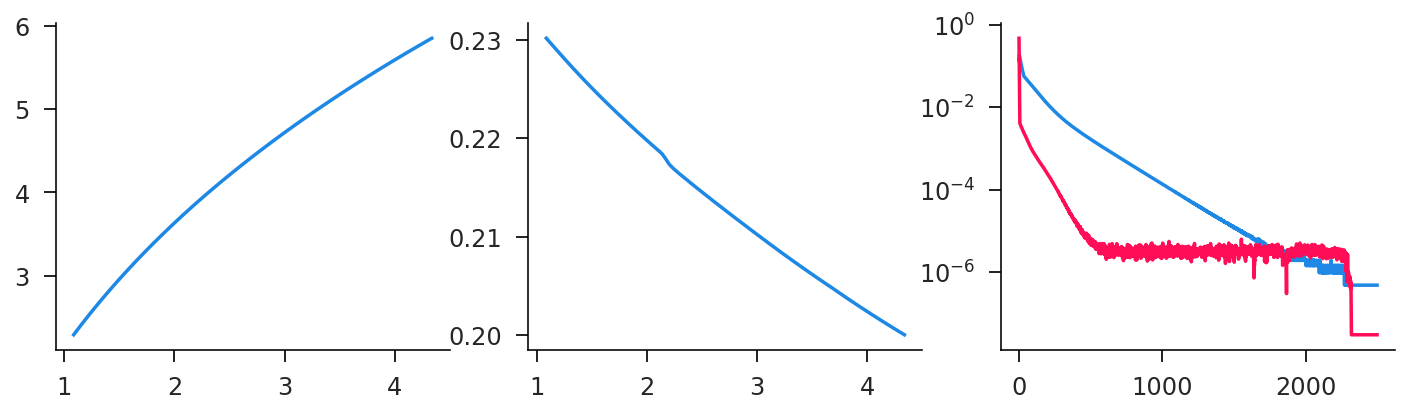

In [15]:
i = -1
t_vec = np.arange(T)
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 3))
ax0.plot(k_grid, ret['v'][i, :]);
ax1.plot(k_grid, ret['i'][i, :])
ax2.plot(t_vec, ret['v_err'], t_vec, ret['i_err']);
ax2.set_yscale('log')

In [16]:
# plot net investment function
def plot_invest(r, p):
    k_diff = r['i'][-1,:] - p['δ']*k_grid
    plt.plot(k_grid, k_diff);
    plt.scatter(k_ss, 0, c='k', zorder=10);
    plt.hlines(0, *plt.xlim(), linestyle='--', linewidth=1, color='k');

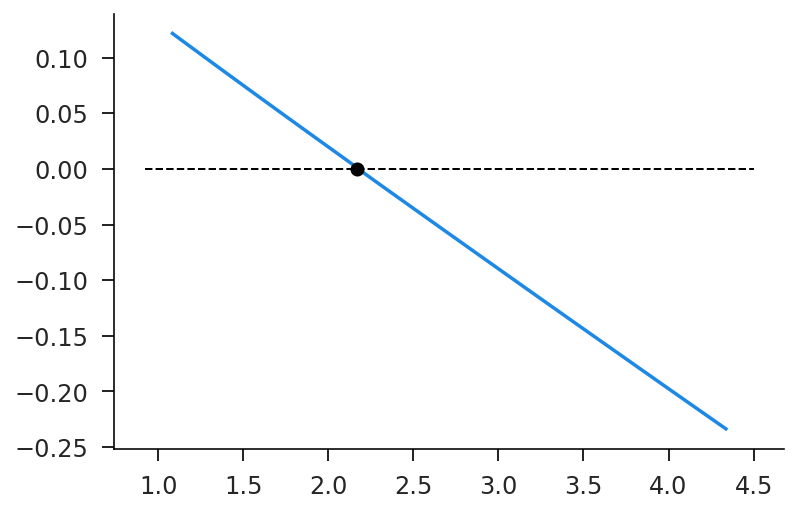

In [17]:
plot_invest(ret, par0)

### Pure Numpy

In [18]:
# pure numpy grid
k_grid0 = np0.linspace(k_min, k_max, N)

In [19]:
def solve_numpy(par):
    # get params
    ρ, z, α = par['ρ'], par['z'], par['α']

    # precompute grid values
    y_grid0 = prod(k_grid0, z, α, np=np0)

    # store history
    v_path = np0.zeros((T, N))
    i_path = np0.zeros((T, N))

    # call value directly
    grid0 = {'y': y_grid0}
    st0 = {'vn': util(y_grid0, np=np0)/ρ, 'iv': np0.zeros(N)}
    tv0 = {}
    for t in range(T):
        stp0, _ = value(par0, grid0, st0, tv0, np=np0)
        st0 = {'vn': stp0['vn'], 'iv': stp0['iv']}
        v_path[t, :] = stp0['vn']
        i_path[t, :] = stp0['iv']

    return {'v': v_path, 'i': i_path}

In [20]:
%time ret0 = solve_numpy(par0)

CPU times: user 26 s, sys: 4.43 s, total: 30.4 s
Wall time: 22.2 s


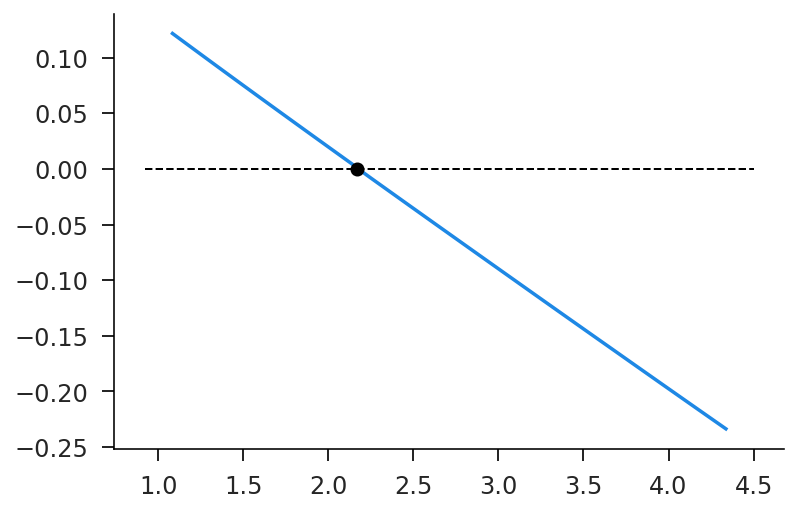

In [21]:
plot_invest(ret0, par0)